Evaluate the impact of a silver-coated mirror vs. an aluminum-coated mirror on stellar colors as a function of metallicity. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import pandas as pd

import rubin_sim.phot_utils as photUtils
import syseng_throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [3]:
srd = False

readnoise = 8.8

# srd true = no losses, X=1.0, fwhm500 = 0.62
# srd false = losses, X=1.2, fwhm500 = 0.72
if srd:
    addLosses = False
else:
    addLosses = True


In [4]:
# Read the non-mirror components - with losses or not depending on srd (without) or not (with)
detector = {}
detector['det'] = st.buildDetector(defaultDirs['detector'], addLosses=addLosses)
detector['e2v'] = st.buildDetector('/'.join(defaultDirs['detector'].split('/')[:-1] + ['e2v']), 
                                   addLosses=addLosses)
detector['itl'] = st.buildDetector('/'.join(defaultDirs['detector'].split('/')[:-1] + ['itl']),
                                  addLosses=addLosses)
lens1 = st.buildLens(defaultDirs['lens1'], addLosses=addLosses)
lens2 = st.buildLens(defaultDirs['lens2'], addLosses=addLosses)
lens3 = st.buildLens(defaultDirs['lens3'], addLosses=addLosses)
filters = st.buildFilters(defaultDirs['filters'], addLosses=addLosses)
if srd:
    X=1.0
    atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
else:
    X=1.2
    atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='pachonModtranAtm_12_aerosol.dat')

# Due to changes in bandpass's default wavelength range, let's do this to make sure everything 300 - 1150
for det in detector:
    detector[det].resample_bandpass()
lens1.resample_bandpass()
lens2.resample_bandpass()
lens3.resample_bandpass()
for f in filters:
    filters[f].resample_bandpass()
atmos.resample_bandpass()

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:67: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:67: UserWarning: Wavelength sampling of 800.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [5]:
# We need a silver mirror and an aluminum mirror
os.listdir(defaultDirs['mirror1']), os.listdir(defaultDirs['mirror2']), os.listdir(defaultDirs['mirror3'])

(['m1_Losses', 'm1_ProtAl_6deg.dat'],
 ['m2_ProtAg_6deg.dat', 'm2_Losses'],
 ['m3_ProtAl_6deg.dat', 'm3_Losses'])

In [6]:
# mirror losses
losses = {}
for m in ('mirror1', 'mirror2', 'mirror3'):
    losses[m] = photUtils.Bandpass()
    losses[m].read_throughput(os.path.join(defaultDirs[m], '%s%s_Losses' % (m[0],m[-1]), 
                                          '%s%s_Losses.dat' % (m[0], m[-1])))
    losses[m].resample_bandpass()

In [7]:
# Mirror losses are not the same (up vs. down-facing), so turn them off for now and add after
mirror = {}
mirror['Al'] = st.buildMirror(defaultDirs['mirror1'], addLosses=False)
mirror['Ag'] = st.buildMirror(defaultDirs['mirror2'], addLosses=False)
# BUT because they are not material dependent and just multiply by the mirror throughput .. 
# we can add them back anyway (as we do below)

for m in mirror:
    mirror[m].resample_bandpass()

In [8]:
# Ok .. 2 combos of mirrors x 2 detectors
combos = [['Al', 'Ag', 'Al'], ['Ag', 'Ag', 'Ag']]


m5 = {}
system_all = {}
for combo in combos:
    comboname = '-'.join(combo)
    system_all[comboname] = {}
    m5[comboname] = {}
    for det in ['e2v', 'itl']:
        hardware = {}
        system = {}
        for f in filters:
            wavelen = detector[det].wavelen
            # Hardware
            sb = detector[det].sb * lens1.sb * lens2.sb * lens3.sb * filters[f].sb
            if not srd:
                sb *= losses['mirror1'].sb * losses['mirror2'].sb * losses['mirror3'].sb
            sb *= mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
            hardware[f] = photUtils.Bandpass()
            hardware[f].set_bandpass(wavelen, sb)
            system[f] = photUtils.Bandpass()
            system[f].set_bandpass(wavelen, sb * atmos.sb)
        system_all[comboname][det] = system
        if srd:
            m5[comboname][det] = st.makeM5(hardware, system, darksky=None, 
                                           exptime=15, nexp=2,
                                           readnoise=8.8, othernoise=0.,
                                           darkcurrent=0.2, fwhm500=0.62, X=1.0)
        else:
            # Default exptime values put u=1x30, grizy = 2x15
            m5[comboname][det] = st.makeM5(hardware, system, darksky=None, 
                                           readnoise=readnoise, othernoise=0.,
                                           darkcurrent=0.2, fwhm500=0.72, X=X)

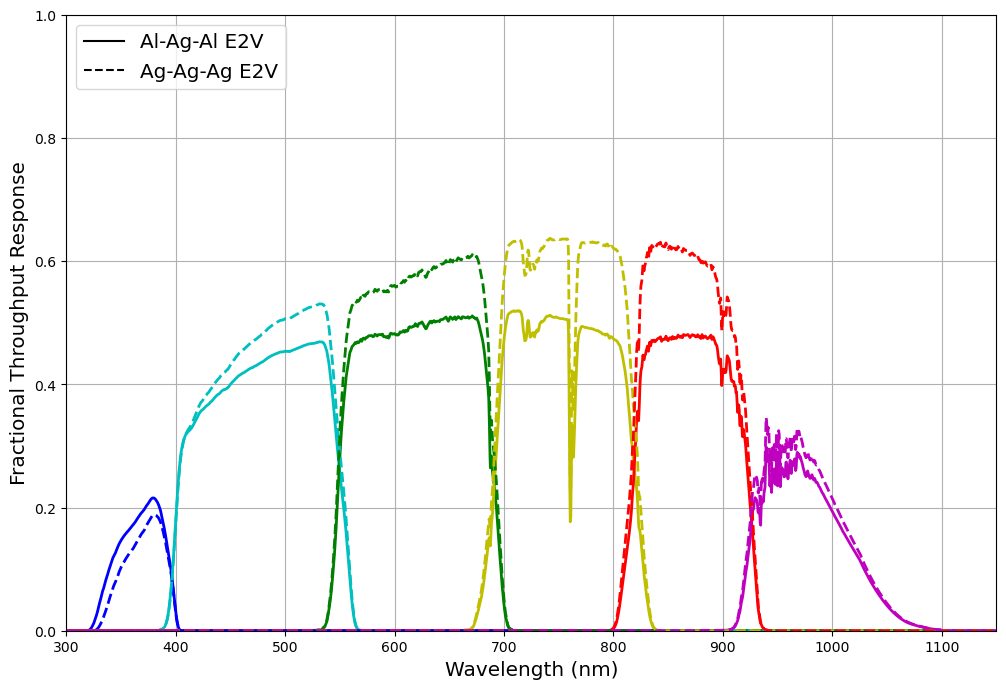

In [9]:
# Plot the entire throughputs
plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo) + ' E2V'
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)]['e2v'], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

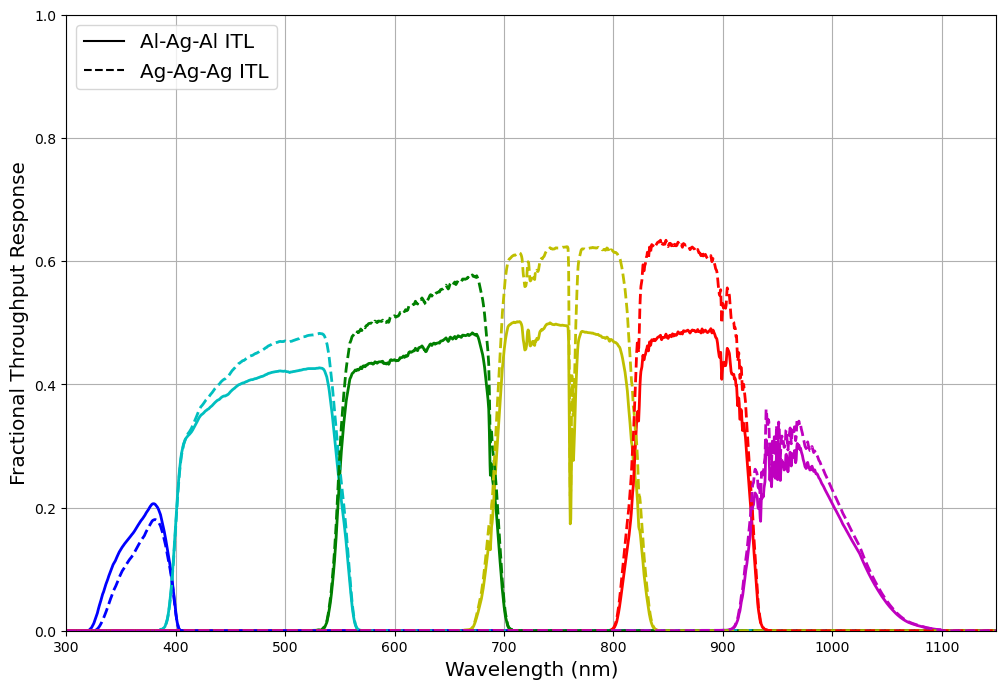

In [10]:
# Plot the entire throughputs
plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo) + ' ITL'
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)]['itl'], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

In [11]:
print('filter vendor Al-Ag-Al Ag-Ag-Ag')
for f in 'ugrizy':
    for det in ['e2v', 'itl']:
        effwavelenphi1, effwavelensb1 = system_all['Al-Ag-Al'][det][f].calc_eff_wavelen()
        effwavelenphi2, effwavelensb2 = system_all['Ag-Ag-Ag'][det][f].calc_eff_wavelen()
        print(f'{f} {det} {effwavelensb1 :.2f} {effwavelensb2 :.2f} {(effwavelensb1/effwavelensb2) :.3f}')

filter vendor Al-Ag-Al Ag-Ag-Ag
u e2v 367.91 371.91 0.989
u itl 368.36 372.37 0.989
g e2v 480.34 481.91 0.997
g itl 479.11 480.69 0.997
r e2v 620.73 621.42 0.999
r itl 621.46 622.15 0.999
i e2v 754.26 755.44 0.998
i itl 754.73 755.90 0.998
z e2v 869.09 867.94 1.001
z itl 869.45 868.29 1.001
y e2v 976.13 975.33 1.001
y itl 976.67 975.87 1.001


Read SED curves over a range of metallicities and temperatures. Use Kurucz models for inputs. (https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/kurucz-1993-models)

In [12]:
sed_dir = '/Users/lynnej/rubin_sim_data/seds/kurucz_r'
kurucz_files = os.listdir(sed_dir)
k_list = []
# make preliminary cut for main sequence, g40 stars & g20 dwarfs
for filename in kurucz_files:
    if filename[-3:] == 'g40':
        k_list.append(filename)
    if filename[-3:] == 'g20':
        k_list.append(filename)
    if filename.startswith('k') and 'fits' in filename:
        k_list.append(filename)
k_list  = list(set(k_list))
atemperature = []
amet = []
alogg = []
# make secondary cut for stars with temperature > 4000 deg
k_list_cut = []
for s in k_list:
    tmp = s.split('_')
    met = float(tmp[0][2:])
    if tmp[0][1] == 'm':
        met = -1 * met        
    met = met/10.0
    temperature = float(tmp[1][:5])
    logg = float(tmp[2][1:])
    logg = logg / 10.0
    if (temperature > 4000.0):
        amet.append(met)
        atemperature.append(temperature)
        alogg.append(logg)
        k_list_cut.append(s)
temperature = np.array(atemperature)
met = np.array(amet)
feh = met - 0.02
logg = np.array(alogg)
k_list = k_list_cut

# actually read the stars SEDS from disk
stars = {}
for s in k_list:
    stars[s] = photUtils.Sed()
    stars[s].read_sed_flambda(os.path.join(sed_dir, s))
print("# Read %d stars from %s" %(len(k_list), sed_dir))
# resample onto the standard bandpass for Bandpass obj's and calculate fnu to speed later calculations
wavelen = system_all['Ag-Ag-Ag']['e2v']['r'].wavelen.copy()
for s in k_list:
    stars[s].synchronize_sed(wavelen_min=wavelen.min, wavelen_max=wavelen.max)
    
print(len(stars), len(met))

# Read 6660 stars from /Users/lynnej/rubin_sim_data/seds/kurucz_r
6660 6660


6660 6660 6660 6660 6660


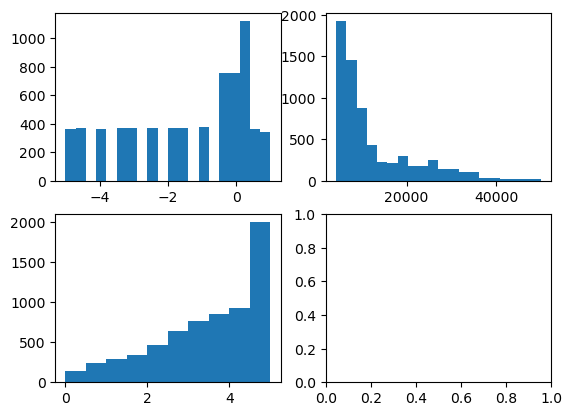

In [13]:
print(len(met), len(logg), len(temperature), len(k_list), len(stars))

fig, axs = plt.subplots(2, 2)

n,b,p = axs[0][0].hist(met, bins=20)
n,b,p = axs[0][1].hist(temperature, bins=20)
n,b,p = axs[1][0].hist(logg)


In [14]:
# Calculate u-g and g-r colors for all of these stars 
ug = {}
gr = {}

for combo in ['Al-Ag-Al', 'Ag-Ag-Ag']:
    ug[combo] = {}
    gr[combo] = {}
    for det in ['e2v', 'itl']:
        ug[combo][det] = np.zeros(len(stars), float)
        gr[combo][det] = np.zeros(len(stars), float)
        for i, s in enumerate(stars):
            u = stars[s].calc_mag(system_all[combo][det]['u'])
            g = stars[s].calc_mag(system_all[combo][det]['g'])
            r = stars[s].calc_mag(system_all[combo][det]['r'])
            ug[combo][det][i] = u - g
            gr[combo][det][i] = g - r

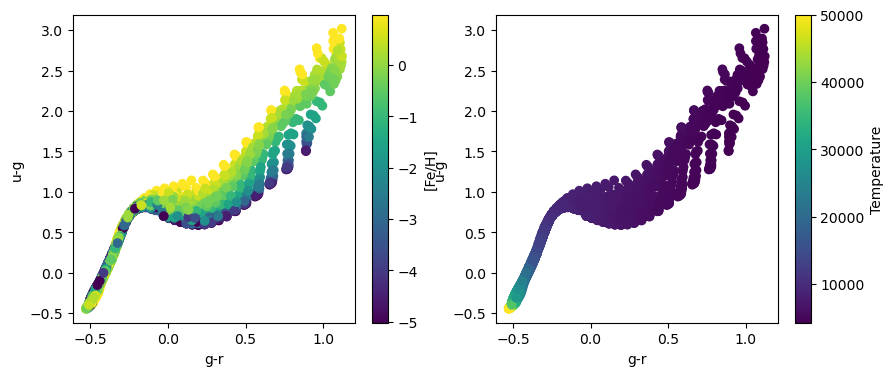

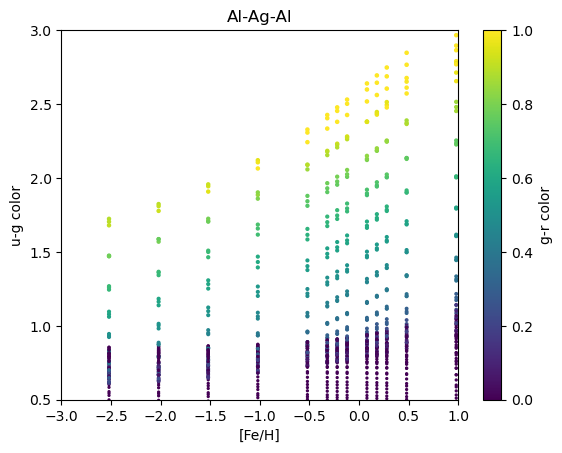

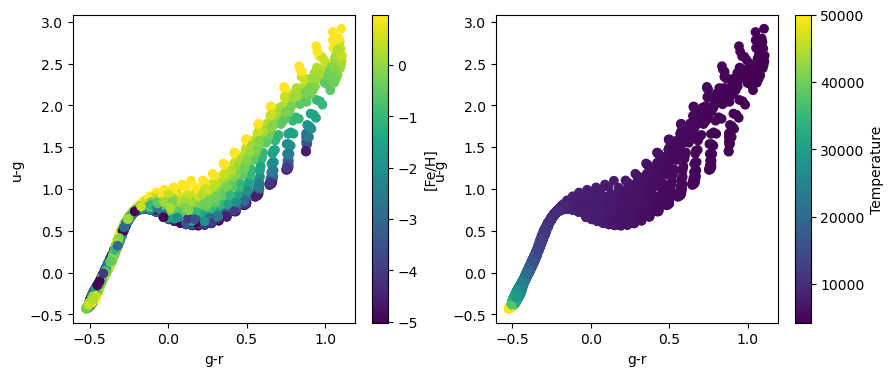

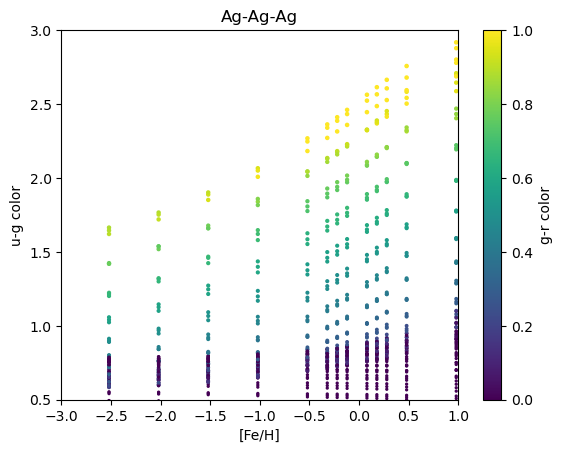

In [15]:
combo = 'Al-Ag-Al'
det = 'e2v'

mask = np.where((logg >= 4) & (logg <= 5))
for combo in ['Al-Ag-Al', 'Ag-Ag-Ag']:
    # plot u-g color as a function of metallicity for bins of g-r colors
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    ax = axs[0]
    s = ax.scatter(gr[combo][det][mask], ug[combo][det][mask], c=feh[mask])
    fig.colorbar(s, label='[Fe/H]', ax=ax)
    ax.set_xlabel('g-r')
    ax.set_ylabel('u-g')
    ax = axs[1]
    s = ax.scatter(gr[combo][det][mask], ug[combo][det][mask], c=temperature[mask])
    fig.colorbar(s, label='Temperature', ax=ax)
    ax.set_xlabel('g-r')
    ax.set_ylabel('u-g')


    plt.figure()
    plt.scatter(feh[mask], ug[combo][det][mask], c=gr[combo][det][mask], s=(gr[combo][det][mask]+1)*10,
                linestyle='', marker='.', vmin=0, vmax=1)
    plt.ylim(0.5, 3.0)
    plt.xlim(-3, 1)
    plt.colorbar(label='g-r color')
    plt.xlabel('[Fe/H]')
    plt.ylabel('u-g color')
    plt.title(combo)

[4.  3.5 3.  4.  3.  3.  3.  3.5 3.5 4.5]


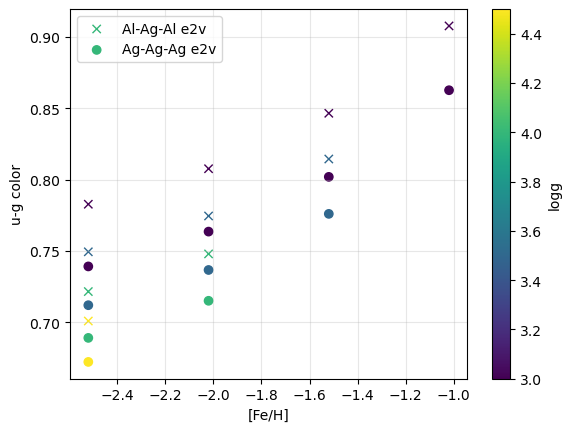

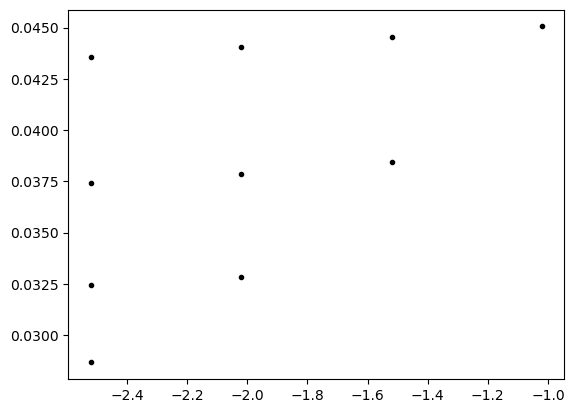

In [23]:
refstar = np.where((np.abs(temperature - 6000) < 100) & 
                   (feh > -3) & (logg > 2.5) &
                   (np.abs(gr[combo][det] - 0.3) < 0.02))
print(logg[refstar])

combo = 'Al-Ag-Al'
det = 'e2v'
plt.scatter(feh[refstar], ug[combo][det][refstar], c=logg[refstar], marker='x', linestyle='', label=f'{combo} {det}')
#det = 'itl'
#plt.scatter(feh[refstar], ug[combo][det][refstar], c=logg[refstar], marker='x', linestyle='', label=f'{combo} {det}')
combo= 'Ag-Ag-Ag'
det = 'e2v'
plt.scatter(feh[refstar], ug[combo][det][refstar], c=logg[refstar], marker='o', linestyle='', label=f'{combo} {det}')
#det = 'itl'
#plt.scatter(feh[refstar], ug[combo][det][refstar], c=logg[refstar], marker='o', linestyle='', label=f'{combo} {det}')
plt.colorbar(label='logg')
plt.legend()
plt.xlabel('[Fe/H]')
plt.ylabel('u-g color')
plt.grid(alpha=0.3)
plt.figure()
plt.plot(feh[refstar], ug['Al-Ag-Al'][det][refstar] - ug['Ag-Ag-Ag'][det][refstar], 'k.')

Text(0, 0.5, 'Change in (u-g) between mirror coatings')

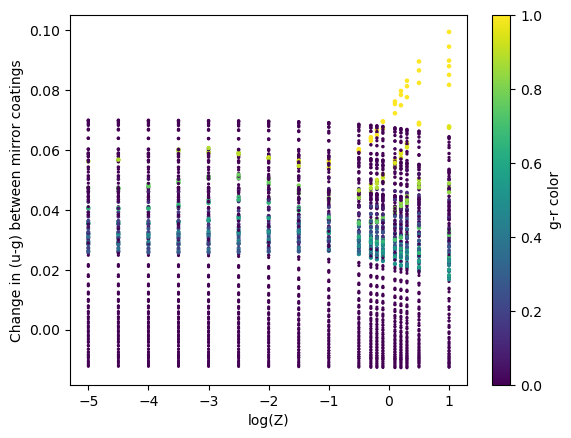

In [17]:
# Maybe just plot the difference in u-g colors .. 

det = 'e2v'

delta = ug['Al-Ag-Al'][det][mask] - ug['Ag-Ag-Ag'][det][mask]

plt.figure()
plt.scatter(met[mask], delta, c=gr[combo][det][mask], s=(gr[combo][det][mask]+1)*10,
            linestyle='', marker='.', vmin=0, vmax=1)
plt.colorbar(label='g-r color')
plt.xlabel('log(Z)')
plt.ylabel('Change in (u-g) between mirror coatings')

Text(0, 0.5, 'Change in (u-g) between mirror coatings')

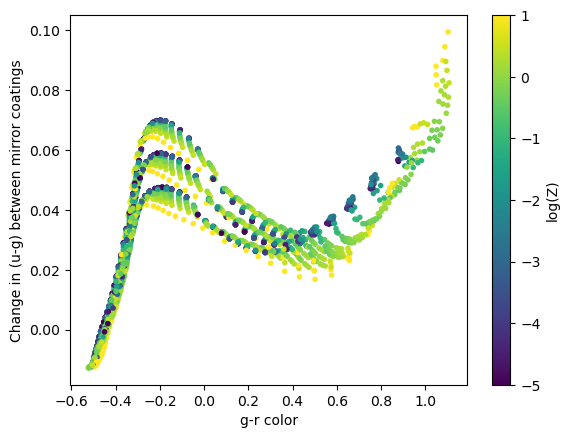

In [18]:
plt.figure()
plt.scatter(gr[combo][det][mask], delta, c=met[mask], #s=(gr[combo][det]+1)*10,
            linestyle='', marker='.')
plt.colorbar(label='log(Z)')
plt.xlabel('g-r color')
plt.ylabel('Change in (u-g) between mirror coatings')

Text(0, 0.5, 'Change in (u-g) between detectors')

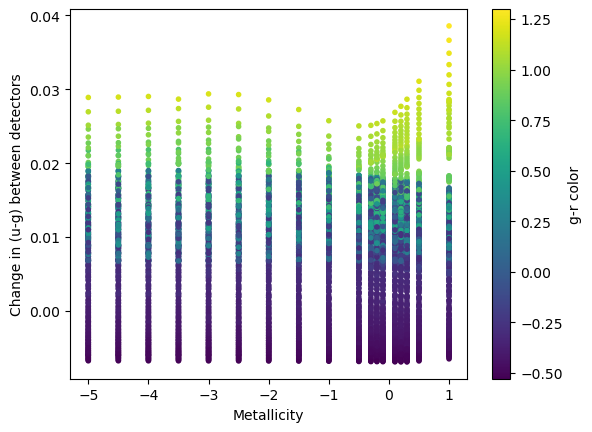

In [19]:
combo = 'Ag-Ag-Ag'
combo = 'Al-Ag-Al'

delta = ug[combo]['e2v'] - ug[combo]['itl']

plt.figure()
plt.scatter(met, delta, c=gr[combo][det], 
            linestyle='', marker='.')
plt.colorbar(label='g-r color')
plt.xlabel('Metallicity')
plt.ylabel('Change in (u-g) between detectors')